In [1]:
# Import necessary modules

import seaborn as sns
import matplotlib.pylab as plt
import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer

import spacy
from spacy import displacy
from spacy.util import minibatch, compounding

from nltk.tokenize import WordPunctTokenizer
import re
from bs4 import BeautifulSoup

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
from nltk.stem import WordNetLemmatizer
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import CountVectorizer

from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Display 100 characters max within a cell
pd.set_option('max_colwidth',200)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/Administrator/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/Administrator/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/Administrator/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
# Read data
df = pd.read_csv('text_emotion.csv')

## Data Understanding and Preprocessing

In [3]:
df.head(10)

,tweet_id,sentiment,author,content
0,1956967341,empty,xoshayzers,@tiffanylue i know i was listenin to bad habit earlier and i started freakin at his part =[
1,1956967666,sadness,wannamama,Layin n bed with a headache ughhhh...waitin on your call...
2,1956967696,sadness,coolfunky,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,czareaquino,wants to hang out with friends SOON!
4,1956968416,neutral,xkilljoyx,"@dannycastillo We want to trade with someone who has Houston tickets, but no one will."
5,1956968477,worry,xxxPEACHESxxx,Re-pinging @ghostridah14: why didn't you go to prom? BC my bf didn't like my friends
6,1956968487,sadness,ShansBee,"I should be sleep, but im not! thinking about an old friend who I want. but he's married now. damn, &amp; he wants me 2! scandalous!"
7,1956968636,worry,mcsleazy,Hmmm. http://www.djhero.com/ is down
8,1956969035,sadness,nic0lepaula,@charviray Charlene my love. I miss you
9,1956969172,sadness,Ingenue_Em,@kelcouch I'm sorry at least it's Friday?


It looks like there are lots of different characters, creative spelling and punctuation, misspellings, slang, new words or URLs. This needs to be fixed

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 4 columns):
tweet_id     40000 non-null int64
sentiment    40000 non-null object
author       40000 non-null object
content      40000 non-null object
dtypes: int64(1), object(3)
memory usage: 1.2+ MB


There are no empty rows, no need to fill/delete NAN values

In [5]:

# Print the count and the ratio of the emotions
pd.DataFrame([df.sentiment.value_counts(), df.sentiment.value_counts(normalize=True)]).T

,sentiment,sentiment
neutral,8638.0,0.215950
worry,8459.0,0.211475
happiness,5209.0,0.130225
sadness,5165.0,0.129125
love,3842.0,0.096050
surprise,2187.0,0.054675
fun,1776.0,0.044400
relief,1526.0,0.038150
hate,1323.0,0.033075
empty,827.0,0.020675


Lets see the group of sentiments on a graph

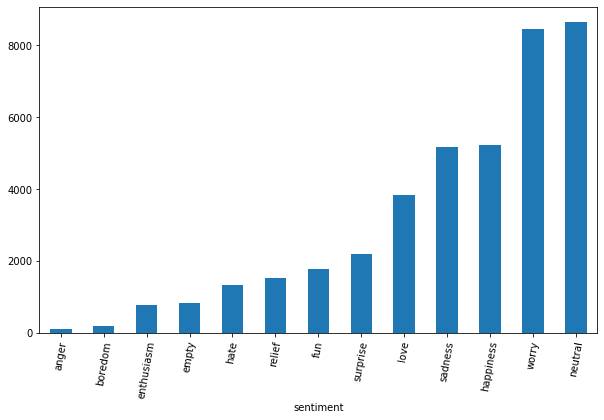

In [6]:
plt.subplots(figsize=(10,6))

df.groupby('sentiment')['content'].count().sort_values(ascending=True).plot(kind='bar')
plt.xticks(rotation=80)
plt.show()

In [7]:
df.describe(include='object')

,sentiment,author,content
count,40000,40000,40000
unique,13,33871,39827
top,neutral,MissxMarisa,I just received a mothers day card from my lovely daughter wishing my a happy mothers day http://tr.im/kWK9
freq,8638,23,14


In [8]:
df.isnull().sum()

tweet_id     0
sentiment    0
author       0
content      0
dtype: int64

No missing values

In [9]:
df.content.duplicated().sum()

173

It looks like there are duplicated tweets (which could be retweets maybe) that needs to be taken into consideration

In [10]:
df.content.value_counts()[df.content.value_counts()>1]

I just received a mothers day card from my lovely daughter wishing my a happy mothers day  http://tr.im/kWK9    14
FREE UNLIMITED RINGTONES!!! - http://tinyurl.com/freeringring - USA ONLY - Awesome 4 iphone                     13
Happy Mother's Day!                                                                                             10
Happy Mothers Day                                                                                               10
happy mother's day                                                                                               8
                                                                                                                ..
good morning!                                                                                                    2
@ericbolling Where's Dani Babb?                                                                                  2
Restoring new iTouch 2.  Excited to use it. Yeeeeeeeee. Goodbye iTouch 1.       

In [11]:
df[df.content=='happy mothers day']

,tweet_id,sentiment,author,content
29348,1751177832,love,jadeeisabel,happy mothers day
36768,1753366853,love,janethglz,happy mothers day
36819,1753381594,happiness,bree_gee,happy mothers day
37340,1753468050,love,starbuckscup,happy mothers day
39131,1753773088,neutral,vwebling,happy mothers day


For the same tweet there are different sentiments in the sentiment column. I decided to drop these duplicates and different labels

In [12]:
df=df.drop_duplicates(subset='content')

In [13]:
df.content.duplicated().sum()

0

Now lets see the distribution of emotions in the data set

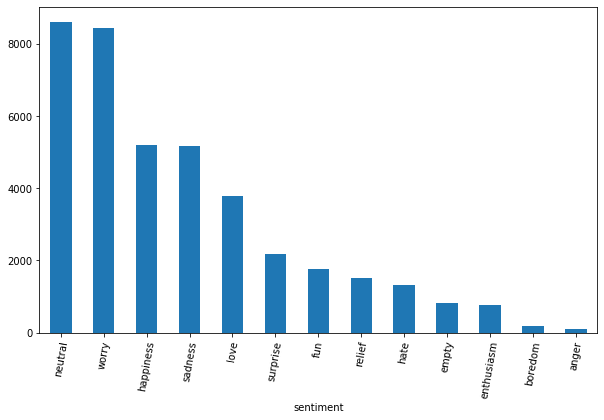

In [14]:
plt.subplots(figsize=(10,6))

df.groupby('sentiment')['content'].count().sort_values(ascending=False).plot(kind='bar')
plt.xticks(rotation=80)
plt.show()

The emotion 'empty' looks different, lets see what is empty 

In [15]:
df[df.sentiment == 'empty'].sample(10)

,tweet_id,sentiment,author,content
20680,1694090110,empty,ani4kaa_hm,@tashkaa hey are you there?Oyy i geas you sleep...
23064,1694550299,empty,Quanghaipk,"@se7en.up cï¿½m on anh ko the chiu noi no~i nhï¿½ Tifa roi :-D, thang Cloud danh dam gi mac ke no :&quot;&gt;"
9666,1962665803,empty,Mig177,I wish I could go to E3. Oh well....
1763,1957392449,empty,dmcn,"@Lacrimae Pfft, there you go with the logic again!"
36393,1753293835,empty,ayamiharu,will go out oh yay me http://plurk.com/p/sv9lc
39492,1753823074,empty,youngnatho,@niariley follow me too
36795,1753380779,empty,Red4Life77,@hollywills hi holly i'll volunteer to try it out first for u! hope ur having a fab weekend xoxox...
14809,1964647372,empty,bretthartwell,@tinacarlino no go on the bro down tonight for brett
18805,1966083365,empty,miszfabulousbby,dont wanna cry but the seniors are out there graduating&amp;its breakin my heart;but im home
9225,1962463416,empty,BonesFan021,@Bookwormlady2 are you not well?


There are different emotions that are categorized es 'empty', even though they should be 'bored', 'happy' or 'sad'. To deal with this, we could clean empty tweets

In [16]:
df=df[df.sentiment!='empty']
df.shape

(39005, 4)

### Cleaning the tweet texts

In [17]:
import string

def tweet_cleaner(tweet):
    
    # To lowercase 
    tweet = tweet.lower()
    
    # Remove HTML special entities (e.g. &amp;)
    tweet = re.sub(r'\&\w*;', '', tweet)
    
    #Convert @username to "@user"
    tweet = re.sub('@[^\s]+','@user',tweet)
    
    # Remove whitespace (including new line characters)
    tweet = re.sub(r'\s\s+', ' ', tweet)
    
    # Remove single space remaining at the front of the tweet.
    tweet = tweet.lstrip(' ')
    
    # Remove characters beyond Basic Multilingual Plane (BMP) of Unicode:
    tweet = ''.join(c for c in tweet if c <= '\uFFFF')
    
    # Remove hyperlinks 
    tweet = re.sub(r'https?:\/\/.*\/\w*', 'http', tweet)
    
    # Remove tickers such as USD ($)
    tweet = re.sub(r'\$\w*', '', tweet)
    
    # Remove hashtags 
    tweet = re.sub(r'#\w*', '', tweet)
    
    # Remove Punctuation and split 's, 't, 've with a space for filter
    tweet  = "".join([char for char in tweet if char not in string.punctuation])
    tweet = re.sub('[0-9]+', ' ', tweet)
    
#     # Spell correction

#     tweet = [speller(w) for w in (nltk.word_tokenize(tweet))]
#     tweet = " ".join(tweet)

    return tweet

In [18]:

df['Cleaned'] = df.content.apply(tweet_cleaner)
df.head(10)

,tweet_id,sentiment,author,content,Cleaned
1,1956967666,sadness,wannamama,Layin n bed with a headache ughhhh...waitin on your call...,layin n bed with a headache ughhhhwaitin on your call
2,1956967696,sadness,coolfunky,Funeral ceremony...gloomy friday...,funeral ceremonygloomy friday
3,1956967789,enthusiasm,czareaquino,wants to hang out with friends SOON!,wants to hang out with friends soon
4,1956968416,neutral,xkilljoyx,"@dannycastillo We want to trade with someone who has Houston tickets, but no one will.",user we want to trade with someone who has houston tickets but no one will
5,1956968477,worry,xxxPEACHESxxx,Re-pinging @ghostridah14: why didn't you go to prom? BC my bf didn't like my friends,repinging user why didnt you go to prom bc my bf didnt like my friends
6,1956968487,sadness,ShansBee,"I should be sleep, but im not! thinking about an old friend who I want. but he's married now. damn, &amp; he wants me 2! scandalous!",i should be sleep but im not thinking about an old friend who i want but hes married now damn he wants me scandalous
7,1956968636,worry,mcsleazy,Hmmm. http://www.djhero.com/ is down,hmmm http is down
8,1956969035,sadness,nic0lepaula,@charviray Charlene my love. I miss you,user charlene my love i miss you
9,1956969172,sadness,Ingenue_Em,@kelcouch I'm sorry at least it's Friday?,user im sorry at least its friday
10,1956969456,neutral,feinyheiny,cant fall asleep,cant fall asleep


### Removing the stopwords

In [19]:
stop = stopwords.words('english')
df['Cleaned'] = df['Cleaned'].apply(lambda x: ' '.join([item for item in x.split() if item not in stop]))
df.head(10)

,tweet_id,sentiment,author,content,Cleaned
1,1956967666,sadness,wannamama,Layin n bed with a headache ughhhh...waitin on your call...,layin n bed headache ughhhhwaitin call
2,1956967696,sadness,coolfunky,Funeral ceremony...gloomy friday...,funeral ceremonygloomy friday
3,1956967789,enthusiasm,czareaquino,wants to hang out with friends SOON!,wants hang friends soon
4,1956968416,neutral,xkilljoyx,"@dannycastillo We want to trade with someone who has Houston tickets, but no one will.",user want trade someone houston tickets one
5,1956968477,worry,xxxPEACHESxxx,Re-pinging @ghostridah14: why didn't you go to prom? BC my bf didn't like my friends,repinging user didnt go prom bc bf didnt like friends
6,1956968487,sadness,ShansBee,"I should be sleep, but im not! thinking about an old friend who I want. but he's married now. damn, &amp; he wants me 2! scandalous!",sleep im thinking old friend want hes married damn wants scandalous
7,1956968636,worry,mcsleazy,Hmmm. http://www.djhero.com/ is down,hmmm http
8,1956969035,sadness,nic0lepaula,@charviray Charlene my love. I miss you,user charlene love miss
9,1956969172,sadness,Ingenue_Em,@kelcouch I'm sorry at least it's Friday?,user im sorry least friday
10,1956969456,neutral,feinyheiny,cant fall asleep,cant fall asleep


In [20]:
wordnet_lemmatizer=WordNetLemmatizer()

df.groupby('sentiment').content.apply(lambda x: ' '.join(x)).\
apply(lambda x: Counter([wordnet_lemmatizer.lemmatize(a) for a in 
                            [k for k in [l for l in [t.lower() for t in word_tokenize(x)] 
                                         if l.isalpha()] if k not in stop]]).most_common(5))

sentiment
anger                        [(get, 9), (quot, 8), (know, 8), (day, 7), (work, 7)]
boredom                [(bored, 27), (im, 19), (work, 15), (really, 12), (go, 12)]
enthusiasm                [(go, 57), (good, 55), (want, 52), (get, 49), (day, 49)]
fun                 [(lol, 184), (fun, 142), (quot, 123), (day, 122), (good, 113)]
happiness     [(day, 679), (good, 559), (happy, 401), (thanks, 297), (great, 296)]
hate                  [(hate, 232), (suck, 95), (like, 94), (work, 89), (get, 85)]
love           [(love, 909), (day, 749), (happy, 546), (mother, 541), (good, 320)]
neutral              [(http, 548), (day, 425), (get, 392), (quot, 386), (go, 381)]
relief              [(day, 172), (good, 126), (thanks, 94), (got, 90), (time, 85)]
sadness              [(day, 427), (sad, 374), (miss, 353), (work, 340), (go, 324)]
surprise              [(quot, 167), (day, 143), (get, 128), (oh, 117), (got, 106)]
worry                 [(get, 566), (day, 532), (go, 479), (like, 457), (got, 

### Let's apply a common words filter for removing most common words 

In [21]:
import pickle

MIN_NUMBER_OF_SR = 500
MIN_COM_WORDS = 0.01
MIN_UNCOM_WORDS = 0.01
UNCOM_WORDS = 0.01
dataframe = df
pivot_feature = 'sentiment'
text_feature = 'Cleaned'

def common_word_filter (dataframe, pivot_feature, text_feature):
    
    NUM_OF_SUB_TECH = len(dataframe[pivot_feature].value_counts()[dataframe[pivot_feature].value_counts() > MIN_NUMBER_OF_SR].index.tolist())
    
    list_common = []
    
    list_uncommon =[]
    
    list_least_common = []
    
    for sub_tech in dataframe[pivot_feature].value_counts()[dataframe[pivot_feature].value_counts() > MIN_NUMBER_OF_SR].index.tolist():
        
        cleaned_text = [str(txt) for text in dataframe[dataframe[pivot_feature] == sub_tech][text_feature] for txt in text.split(' ') if len(txt) > 2 and txt not in ' ']
        
        word_dist = nltk.FreqDist(cleaned_text)
        
        list_common.append([x[0] for x in word_dist.most_common(int(len(word_dist)*MIN_COM_WORDS))])
        
        list_uncommon.append([x[0] for x in word_dist.most_common(len(word_dist))[-int(len(word_dist)*MIN_UNCOM_WORDS):]])
        
        list_least_common.append([x[0] for x in word_dist.most_common(len(word_dist))[-int(len(word_dist)*UNCOM_WORDS):]])
    
    list_common_fl = [x for y in list_common for x in y]
    
    list_uncommon_fl = [x for y in list_uncommon for x in y]
    
    word_dist_com = nltk.FreqDist(list_common_fl)
    
    word_dist_ucom = nltk.FreqDist(list_uncommon_fl)
    
    list_final_com = [x[0] for x in word_dist_com.most_common(len(list_common_fl)) if x[1] > NUM_OF_SUB_TECH*0.75]
    
    list_final_ucom = [x[0] for x in word_dist_ucom.most_common(len(list_uncommon_fl)) if x[1] < NUM_OF_SUB_TECH*0.25]
    
    final_list = list(set(list_final_com + list_final_ucom + [y for x in list_least_common for y in x]))
    
    with open('common_word_list_for_filtering.pickle', 'wb') as handle:
    
        pickle.dump(final_list, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    return final_list



In [22]:
final_list = common_word_filter(df, 'sentiment','Cleaned')

In [23]:
len(final_list)

678

In [24]:
len(df.content)

39005

In [25]:
df['Cleaned'] = df['Cleaned'].apply(lambda x: ' '.join([word for word in x.split() if word not in (final_list)]))
df.head()

,tweet_id,sentiment,author,content,Cleaned
1,1956967666,sadness,wannamama,Layin n bed with a headache ughhhh...waitin on your call...,layin n bed headache ughhhhwaitin call
2,1956967696,sadness,coolfunky,Funeral ceremony...gloomy friday...,funeral ceremonygloomy friday
3,1956967789,enthusiasm,czareaquino,wants to hang out with friends SOON!,wants hang friends soon
4,1956968416,neutral,xkilljoyx,"@dannycastillo We want to trade with someone who has Houston tickets, but no one will.",trade someone houston tickets
5,1956968477,worry,xxxPEACHESxxx,Re-pinging @ghostridah14: why didn't you go to prom? BC my bf didn't like my friends,repinging didnt go prom bc bf didnt friends


### Vectorizing the Data before applying models

### Count vectorizing

In [26]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(df['Cleaned'],
                                                    df['sentiment'],
                                                    test_size=.20, random_state=53)

In [27]:
count_vect1 = CountVectorizer(min_df=0.001)
count_vect_train1 = count_vect1.fit_transform(X_train1)
count_vect_train1 = count_vect_train1.toarray()
count_vect_test1 = count_vect1.transform(X_test1)
count_vect_test1 = count_vect_test1.toarray()

### Logistic Regression

In [28]:
logreg_CV1 = LogisticRegression(multi_class='multinomial', solver='newton-cg',class_weight='balanced',
                              C=1.0,n_jobs=-1, random_state=5)
logreg_CV1.fit(count_vect_train1, y_train1)
y_pred_lr_CV1 = logreg_CV1.predict(count_vect_test1)
print('Accuracy :', metrics.accuracy_score(y_test1, y_pred_lr_CV1))

Accuracy : 0.2208691193436739


Because of the feuture distribution of the sample, we were expecting a low accuracy in our model. In order to balance the distribution, we can update the categorization of the emotions.

We have 13 emotions and we can categorize them in 3 sentiment categories: positive, neutral and negative

anger, boredom, hate, worry, sadness: Negative

happiness, fun, love, surprise, enthusiasm, relief: Positive

empty, neutral : Neutral

In [29]:
# Create a new dataframe with new 3 sentiments
dfnew=df.copy()

In [30]:
dfnew.sentiment.replace(['anger','boredom','hate','worry','sadness','happiness','fun','love','surprise','enthusiasm','relief','empty','neutral'],
                    ['negative','negative','negative','negative','negative','positive','positive','positive','positive','positive','positive','neutral','neutral'],
                       inplace=True)

In [31]:
dfnew.head()

,tweet_id,sentiment,author,content,Cleaned
1,1956967666,negative,wannamama,Layin n bed with a headache ughhhh...waitin on your call...,layin n bed headache ughhhhwaitin call
2,1956967696,negative,coolfunky,Funeral ceremony...gloomy friday...,funeral ceremonygloomy friday
3,1956967789,positive,czareaquino,wants to hang out with friends SOON!,wants hang friends soon
4,1956968416,neutral,xkilljoyx,"@dannycastillo We want to trade with someone who has Houston tickets, but no one will.",trade someone houston tickets
5,1956968477,negative,xxxPEACHESxxx,Re-pinging @ghostridah14: why didn't you go to prom? BC my bf didn't like my friends,repinging didnt go prom bc bf didnt friends


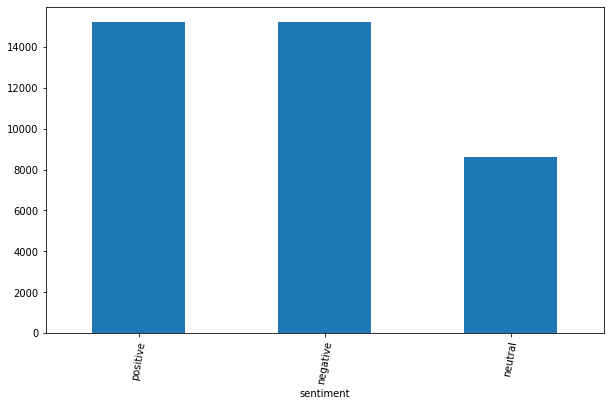

In [32]:
plt.subplots(figsize=(10,6))

dfnew.groupby('sentiment')['content'].count().sort_values(ascending=False).plot(kind='bar')
plt.xticks(rotation=80)
plt.show()

Because of the imbalance in the distribution and the low result in emotions data set, adding more labeled data could be helpful

In [33]:
dfadd = pd.read_csv('additionalclean.csv')

In [34]:
dfbig = pd.concat([dfnew, dfadd], ignore_index=True, sort =False)
dfbig.shape

(53432, 6)

In [35]:
dfbig.head()

,tweet_id,sentiment,author,content,Cleaned,Unnamed: 0
0,1.956968e+09,negative,wannamama,Layin n bed with a headache ughhhh...waitin on your call...,layin n bed headache ughhhhwaitin call,NaN
1,1.956968e+09,negative,coolfunky,Funeral ceremony...gloomy friday...,funeral ceremonygloomy friday,NaN
2,1.956968e+09,positive,czareaquino,wants to hang out with friends SOON!,wants hang friends soon,NaN
3,1.956968e+09,neutral,xkilljoyx,"@dannycastillo We want to trade with someone who has Houston tickets, but no one will.",trade someone houston tickets,NaN
4,1.956968e+09,negative,xxxPEACHESxxx,Re-pinging @ghostridah14: why didn't you go to prom? BC my bf didn't like my friends,repinging didnt go prom bc bf didnt friends,NaN


There is an extra column occured, needs to be dropped

In [36]:
dfbig = dfbig.drop(['Unnamed: 0'], axis=1)
# dfnew=dfbig
dfbig.head()

,tweet_id,sentiment,author,content,Cleaned
0,1.956968e+09,negative,wannamama,Layin n bed with a headache ughhhh...waitin on your call...,layin n bed headache ughhhhwaitin call
1,1.956968e+09,negative,coolfunky,Funeral ceremony...gloomy friday...,funeral ceremonygloomy friday
2,1.956968e+09,positive,czareaquino,wants to hang out with friends SOON!,wants hang friends soon
3,1.956968e+09,neutral,xkilljoyx,"@dannycastillo We want to trade with someone who has Houston tickets, but no one will.",trade someone houston tickets
4,1.956968e+09,negative,xxxPEACHESxxx,Re-pinging @ghostridah14: why didn't you go to prom? BC my bf didn't like my friends,repinging didnt go prom bc bf didnt friends


Now we can re-train our new and clean data set 

### Wordcloud

#### Positive

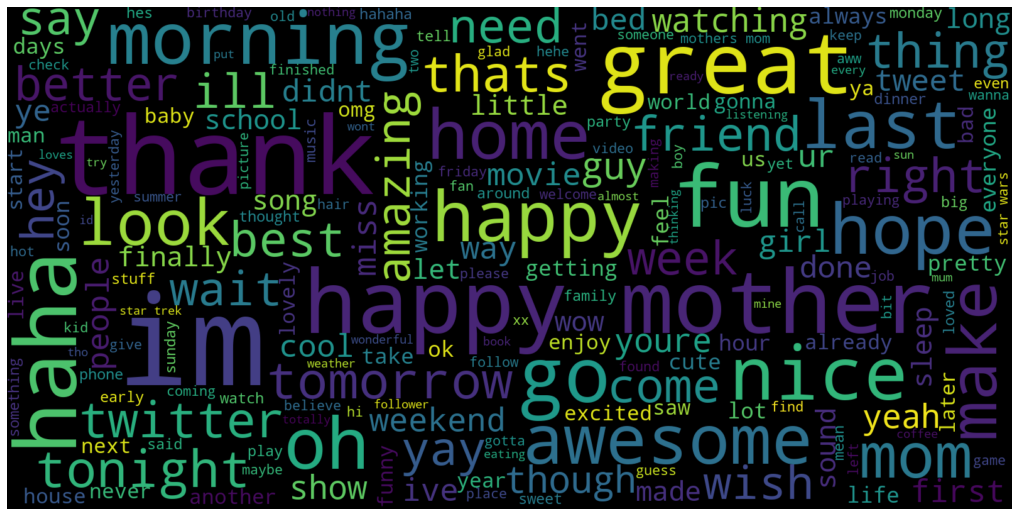

In [37]:

from wordcloud import WordCloud


wordcloud = WordCloud(width=1600, height=800,max_font_size=200,colormap='viridis').\
generate(dfnew[dfnew.sentiment=='positive'].Cleaned.str.cat(sep=' '))
plt.figure(figsize=(18,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Wordcloud for the uncleaned text (original)

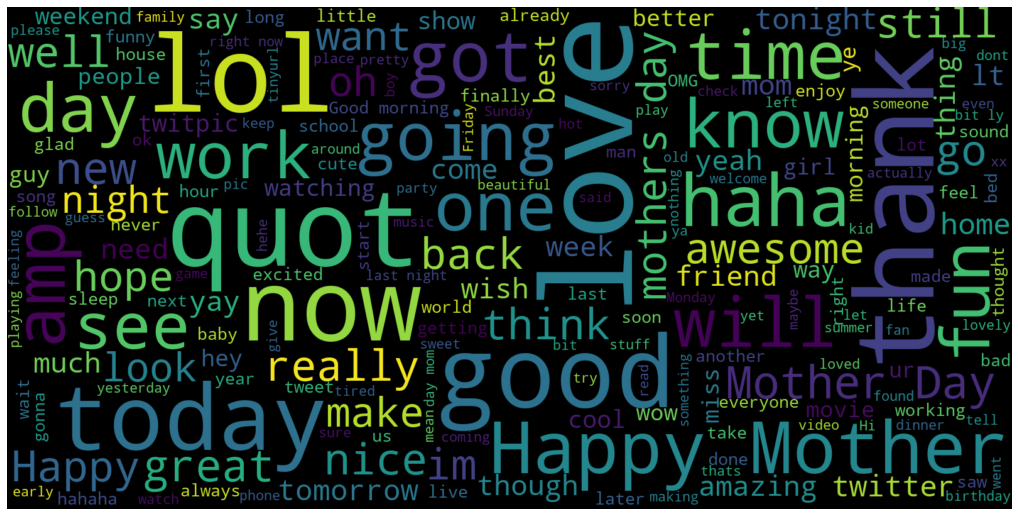

In [38]:
wordcloud = WordCloud(width=1600, height=800,max_font_size=200,colormap='viridis').\
generate(dfnew[dfnew.sentiment=='positive'].content.str.cat(sep=' '))
plt.figure(figsize=(18,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

#### Neutral

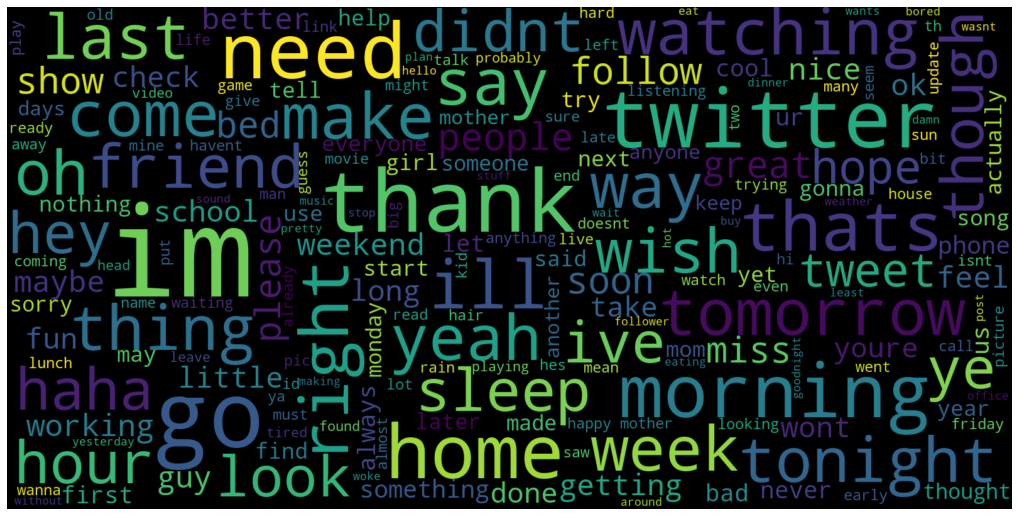

In [39]:
wordcloud = WordCloud(width=1600, height=800,max_font_size=200,colormap='viridis').\
generate(dfnew[dfnew.sentiment=='neutral'].Cleaned.str.cat(sep=' '))
plt.figure(figsize=(18,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

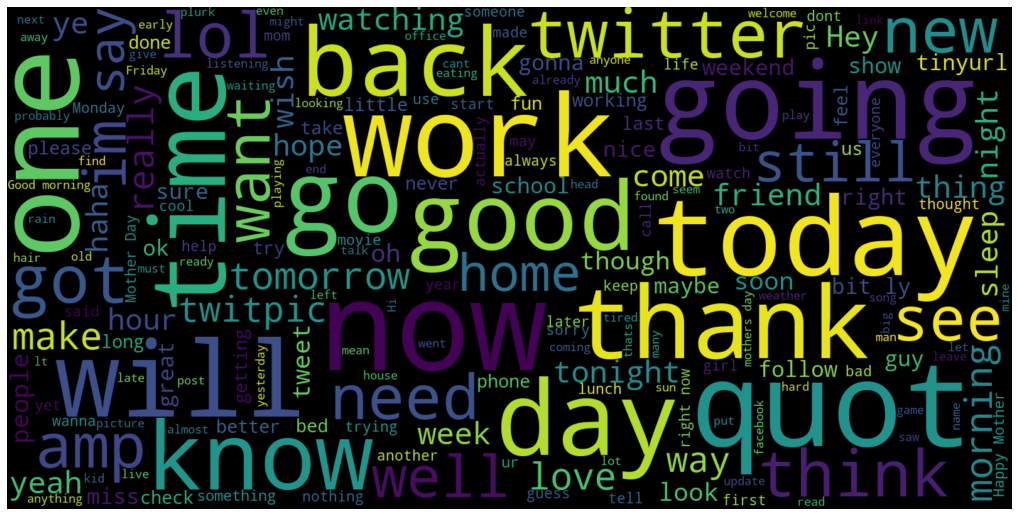

In [40]:
wordcloud = WordCloud(width=1600, height=800,max_font_size=200,colormap='viridis').\
generate(dfnew[dfnew.sentiment=='neutral'].content.str.cat(sep=' '))
plt.figure(figsize=(18,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

#### Negative

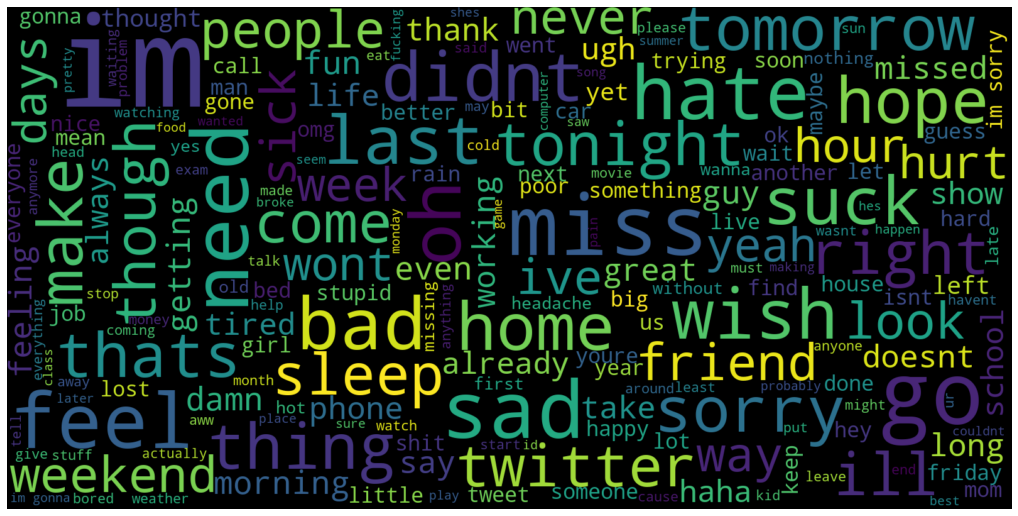

In [41]:
wordcloud = WordCloud(width=1600, height=800,max_font_size=200,colormap='viridis').\
generate(dfnew[dfnew.sentiment=='negative'].Cleaned.str.cat(sep=' '))
plt.figure(figsize=(18,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

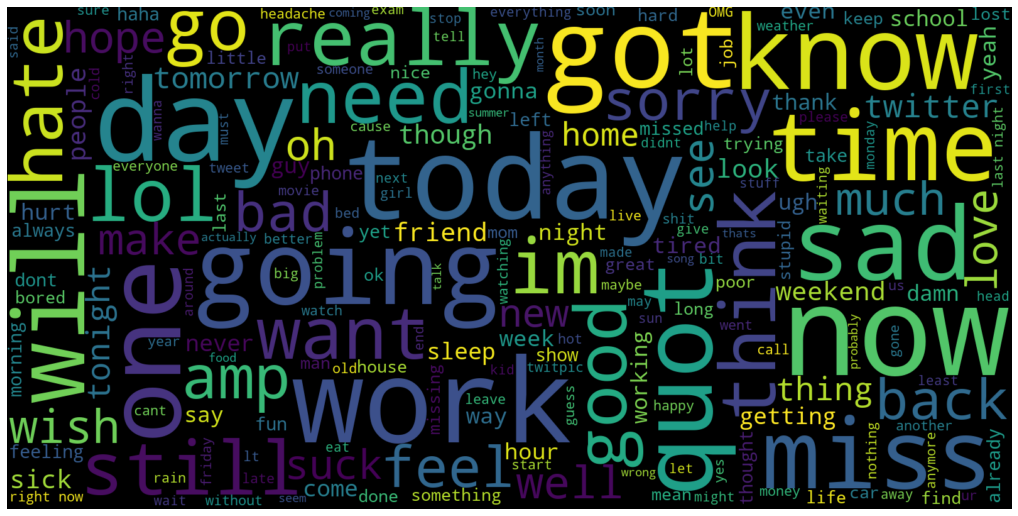

In [42]:
wordcloud = WordCloud(width=1600, height=800,max_font_size=200,colormap='viridis').\
generate(dfnew[dfnew.sentiment=='negative'].content.str.cat(sep=' '))
plt.figure(figsize=(18,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Lets apply tokenization and lemmatization after categorizing in 3 sentiments

In [43]:
dfnew.shape

(39005, 5)

In [44]:
wordnet_lemmatizer=WordNetLemmatizer()

dfmostc=dfnew.groupby('sentiment').content.apply(lambda x: ' '.join(x)).\
apply(lambda x: Counter([wordnet_lemmatizer.lemmatize(a) for a in 
                            [k for k in [l for l in [t.lower() for t in word_tokenize(x)] 
                                         if l.isalpha()] if (k not in stop) and (k!='http' and k!='quot') ]]).most_common(20))

dfmostc

sentiment
negative    [(day, 1042), (get, 987), (go, 877), (like, 853), (work, 853), (got, 782), (today, 702), (going, 662), (ca, 632), (good, 631), (im, 620), (sad, 619), (miss, 609), (really, 605), (know, 587), (u, 5...
neutral     [(day, 425), (get, 392), (go, 381), (good, 351), (work, 350), (like, 343), (one, 330), (u, 320), (going, 312), (got, 310), (back, 289), (time, 283), (know, 283), (today, 279), (want, 225), (twitte...
positive    [(day, 1914), (love, 1286), (good, 1269), (happy, 1091), (mother, 887), (lol, 774), (like, 746), (u, 728), (got, 720), (get, 704), (thanks, 673), (time, 647), (today, 627), (go, 606), (great, 600)...
Name: content, dtype: object

Now lets see the distribution of most common tokens in each sentiment

In [45]:
dfnew=dfbig.copy()

## Lets try NLTK Vader for sentiment comparison

NLTK Vader is a parsimonious rule-based model for sentiment snalysis of social media text. With vader, we can compare our dataset's classification with the Vader classification

In [46]:

nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/Administrator/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [47]:
def sentiment_analyzer_scores(sentence):
    '''
    Evaluates polarity scores of a given sentence and prints the result.
    '''
    score = analyzer.polarity_scores(sentence)
    print("{:-<40} {}".format(sentence, str(score)))

analyzer = SentimentIntensityAnalyzer()

In [48]:

sentiments = []
compounds = []
sid = SentimentIntensityAnalyzer()
for i in dfnew.content:
    sentiment = sid.polarity_scores(i)
    if sentiment['compound']< -0.05:
        sentiments.append('negative')    
    elif sentiment['compound']> 0.05:
        sentiments.append('positive')
    else:
        sentiments.append('neutral')
    compounds.append(sentiment)
    
dfnew['vader'] = pd.DataFrame(sentiments)
dfnew['compound'] = compounds


In [49]:
dfnew.head(10)

,tweet_id,sentiment,author,content,Cleaned,vader,compound
0,1.956968e+09,negative,wannamama,Layin n bed with a headache ughhhh...waitin on your call...,layin n bed headache ughhhhwaitin call,neutral,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}"
1,1.956968e+09,negative,coolfunky,Funeral ceremony...gloomy friday...,funeral ceremonygloomy friday,negative,"{'neg': 0.556, 'neu': 0.444, 'pos': 0.0, 'compound': -0.3612}"
2,1.956968e+09,positive,czareaquino,wants to hang out with friends SOON!,wants hang friends soon,positive,"{'neg': 0.0, 'neu': 0.639, 'pos': 0.361, 'compound': 0.5255}"
3,1.956968e+09,neutral,xkilljoyx,"@dannycastillo We want to trade with someone who has Houston tickets, but no one will.",trade someone houston tickets,negative,"{'neg': 0.165, 'neu': 0.767, 'pos': 0.068, 'compound': -0.3919}"
4,1.956968e+09,negative,xxxPEACHESxxx,Re-pinging @ghostridah14: why didn't you go to prom? BC my bf didn't like my friends,repinging didnt go prom bc bf didnt friends,negative,"{'neg': 0.264, 'neu': 0.736, 'pos': 0.0, 'compound': -0.5667}"
5,1.956968e+09,negative,ShansBee,"I should be sleep, but im not! thinking about an old friend who I want. but he's married now. damn, &amp; he wants me 2! scandalous!",sleep im thinking old friend hes married damn wants scandalous,negative,"{'neg': 0.26, 'neu': 0.575, 'pos': 0.165, 'compound': -0.6458}"
6,1.956969e+09,negative,mcsleazy,Hmmm. http://www.djhero.com/ is down,hmmm,neutral,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}"
7,1.956969e+09,negative,nic0lepaula,@charviray Charlene my love. I miss you,charlene miss,positive,"{'neg': 0.163, 'neu': 0.408, 'pos': 0.429, 'compound': 0.5574}"
8,1.956969e+09,negative,Ingenue_Em,@kelcouch I'm sorry at least it's Friday?,im sorry least friday,negative,"{'neg': 0.178, 'neu': 0.822, 'pos': 0.0, 'compound': -0.0772}"
9,1.956969e+09,neutral,feinyheiny,cant fall asleep,fall asleep,neutral,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}"


In [50]:
dfnew=dfnew[['tweet_id','author','content','Cleaned','sentiment','vader','compound']]
dfnew.head(20)

,tweet_id,author,content,Cleaned,sentiment,vader,compound
0,1.956968e+09,wannamama,Layin n bed with a headache ughhhh...waitin on your call...,layin n bed headache ughhhhwaitin call,negative,neutral,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}"
1,1.956968e+09,coolfunky,Funeral ceremony...gloomy friday...,funeral ceremonygloomy friday,negative,negative,"{'neg': 0.556, 'neu': 0.444, 'pos': 0.0, 'compound': -0.3612}"
2,1.956968e+09,czareaquino,wants to hang out with friends SOON!,wants hang friends soon,positive,positive,"{'neg': 0.0, 'neu': 0.639, 'pos': 0.361, 'compound': 0.5255}"
3,1.956968e+09,xkilljoyx,"@dannycastillo We want to trade with someone who has Houston tickets, but no one will.",trade someone houston tickets,neutral,negative,"{'neg': 0.165, 'neu': 0.767, 'pos': 0.068, 'compound': -0.3919}"
4,1.956968e+09,xxxPEACHESxxx,Re-pinging @ghostridah14: why didn't you go to prom? BC my bf didn't like my friends,repinging didnt go prom bc bf didnt friends,negative,negative,"{'neg': 0.264, 'neu': 0.736, 'pos': 0.0, 'compound': -0.5667}"
5,1.956968e+09,ShansBee,"I should be sleep, but im not! thinking about an old friend who I want. but he's married now. damn, &amp; he wants me 2! scandalous!",sleep im thinking old friend hes married damn wants scandalous,negative,negative,"{'neg': 0.26, 'neu': 0.575, 'pos': 0.165, 'compound': -0.6458}"
6,1.956969e+09,mcsleazy,Hmmm. http://www.djhero.com/ is down,hmmm,negative,neutral,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}"
7,1.956969e+09,nic0lepaula,@charviray Charlene my love. I miss you,charlene miss,negative,positive,"{'neg': 0.163, 'neu': 0.408, 'pos': 0.429, 'compound': 0.5574}"
8,1.956969e+09,Ingenue_Em,@kelcouch I'm sorry at least it's Friday?,im sorry least friday,negative,negative,"{'neg': 0.178, 'neu': 0.822, 'pos': 0.0, 'compound': -0.0772}"
9,1.956969e+09,feinyheiny,cant fall asleep,fall asleep,neutral,neutral,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}"


In [51]:
for i in dfnew.index[0:10]:
    print(i)
    sentiment_analyzer_scores(dfnew.content[i])

0
Layin n bed with a headache  ughhhh...waitin on your call... {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
1
Funeral ceremony...gloomy friday...----- {'neg': 0.556, 'neu': 0.444, 'pos': 0.0, 'compound': -0.3612}
2
wants to hang out with friends SOON!---- {'neg': 0.0, 'neu': 0.639, 'pos': 0.361, 'compound': 0.5255}
3
@dannycastillo We want to trade with someone who has Houston tickets, but no one will. {'neg': 0.165, 'neu': 0.767, 'pos': 0.068, 'compound': -0.3919}
4
Re-pinging @ghostridah14: why didn't you go to prom? BC my bf didn't like my friends {'neg': 0.264, 'neu': 0.736, 'pos': 0.0, 'compound': -0.5667}
5
I should be sleep, but im not! thinking about an old friend who I want. but he's married now. damn, &amp; he wants me 2! scandalous! {'neg': 0.26, 'neu': 0.575, 'pos': 0.165, 'compound': -0.6458}
6
Hmmm. http://www.djhero.com/ is down---- {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
7
@charviray Charlene my love. I miss you- {'neg': 0.163, 'neu': 0.408, 'pos'

Let's compare the sentiments in our data and the 'Vader' results

In [52]:
(dfnew.sentiment==dfnew.vader).mean()

0.5442431501721815

In [53]:
dfnew[dfnew.sentiment!=dfnew.vader].sample(10)

,tweet_id,author,content,Cleaned,sentiment,vader,compound
42853,5.680680e+17,681453851,@united we have been told that it's lost...you guys don't know where it is,@user told lost...you guys know,negative,neutral,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}"
1139,1.957233e+09,Hail_zzz,Gonna go watch Shorty Street &amp; then prison break marathon then bed maybe. Nobodies texting me!,gonna go watch shorty street prison break marathon bed maybe nobodies texting,positive,negative,"{'neg': 0.193, 'neu': 0.807, 'pos': 0.0, 'compound': -0.5562}"
28010,1.750932e+09,Aboundlessworld,@jeffpower What are you reading?,reading,negative,neutral,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}"
26981,1.695883e+09,rinaloveslife,time to hit the study notes! prep for friday's exam!,hit study notes prep fridays exam,negative,neutral,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}"
40902,5.695280e+17,681451071,@united any chance you could help rebook?? My flight Cancelled Flightled,@user chance could help rebook?? My flight Cancelled Flightled,negative,positive,"{'neg': 0.133, 'neu': 0.531, 'pos': 0.336, 'compound': 0.4696}"
18805,1.966221e+09,hrhnikkiawesome,i just bit my tongue. blood everywhere!!!,bit tongue blood everywhere,negative,neutral,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}"
47204,5.685800e+17,681459015,@JetBlue here in Austin I saw the water bottles &amp; snacks @ the desk for your waiting passengers! Im so Flight Booking Problems my next flight with you!,@user Austin I saw water bottles snacks @ desk waiting passengers! Im Flight Booking Problems next flight you!,positive,negative,"{'neg': 0.124, 'neu': 0.876, 'pos': 0.0, 'compound': -0.5496}"
3308,1.958035e+09,hopeless,Cashflow forecasts are fun but big red numbers aren't,cashflow forecasts fun big red numbers arent,neutral,positive,"{'neg': 0.0, 'neu': 0.788, 'pos': 0.212, 'compound': 0.2846}"
24192,1.694929e+09,Silvermoon28,"Baby baby, it's gonna be all right when I'm by your side and the whole world turns against you... I ? it when my Ipod randoms BSB songs",baby baby gonna right im side whole world turns ipod randoms bsb songs,negative,neutral,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}"
44352,5.691640e+17,681455367,@SouthwestAir - been on hold forever. My first flight was Cancelled Flightled but my 2nd flight is still on time - HELP!,@user - hold forever. My first flight Cancelled Flightled 2nd flight still time - HELP!,negative,positive,"{'neg': 0.061, 'neu': 0.736, 'pos': 0.202, 'compound': 0.6642}"


It looks like, our dataset's classification is better than vader's classification. On the other hand, it is obvious that (because twitter texts are very short) our common words cleaner cleaned more than needed. 

## Train-Test Split

In [54]:

X_train, X_test, y_train, y_test = train_test_split(dfnew['Cleaned'],
                                                    dfnew['sentiment'],
                                                    test_size=.25, random_state=53)

## Count Vectirizing

In [55]:
count_vect = CountVectorizer(min_df=0.001)
count_vect_train = count_vect.fit_transform(X_train)
count_vect_train = count_vect_train.toarray()
count_vect_test = count_vect.transform(X_test)
count_vect_test = count_vect_test.toarray()

In [56]:
vocab = count_vect.get_feature_names()

In [57]:
pd.DataFrame(count_vect_train, columns=vocab).head(10)

,10,11,12,15,1st,20,200,24,25,2nd,...,you,youll,your,youre,youtube,youve,yr,yum,yummy,ûï
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Logistic Regression

In [58]:

logreg_CV = LogisticRegression(random_state=0)
logreg_CV.fit(count_vect_train, y_train)
y_pred_lr_CV = logreg_CV.predict(count_vect_test)
print('Accuracy :', metrics.accuracy_score(y_test, y_pred_lr_CV))

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Accuracy : 0.6158856116185057


##  Linear SVC

In [59]:

Lsvc = LinearSVC()

Lsvc.fit(count_vect_train, y_train)

pred= Lsvc.predict(count_vect_test)

metrics.accuracy_score(y_test, pred)

/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.6156610270998653

## Naive Bayes

In [60]:

from sklearn.naive_bayes import MultinomialNB

nb_classifier = MultinomialNB()

nb_classifier.fit(count_vect_train, y_train)

pred = nb_classifier.predict(count_vect_test)

metrics.accuracy_score(y_test, pred)

0.566701602036233

## Random Forest

In [61]:
from sklearn.ensemble import RandomForestClassifier
rf_CV = RandomForestClassifier(random_state=0, n_jobs=-1, class_weight="balanced", n_estimators = 200)
rf_CV.fit(count_vect_train, y_train)
y_pred_rf_CV = rf_CV.predict(count_vect_test)
print('Accuracy :', metrics.accuracy_score(y_test, y_pred_rf_CV))

Accuracy : 0.5810001497230124


## Gradient Boosting

In [80]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
# import xgboost as xgb
from xgboost import XGBClassifier

xg_boost_CV = XGBClassifier()
xg_boost_CV.fit(count_vect_train, y_train)
y_pred_xg_boost = xg_boost_CV.predict(count_vect_test)
print('Accuracy :', metrics.accuracy_score(y_test, y_pred_xg_boost))

Accuracy : 0.5488097020512053


## XGBOOST

In [81]:

xg_boost_CV = XGBClassifier()
xg_boost_CV.fit(count_vect_train, y_train)
y_pred_xg_boost = xg_boost_CV.predict(count_vect_test)
print('Accuracy :', metrics.accuracy_score(y_test, y_pred_xg_boost))

Accuracy : 0.5488097020512053


## Tf-idf Vectorization¶

In [62]:
tfidf_vect = TfidfVectorizer(min_df=1, max_df=1.0, use_idf=True)
tfidf_vect_train = tfidf_vect.fit_transform(X_train)
tfidf_vect_train = tfidf_vect_train.toarray()
tfidf_vect_test = tfidf_vect.transform(X_test)
vocab = tfidf_vect.get_feature_names()
pd.DataFrame(np.round(tfidf_vect_train, 2), columns=vocab).head(10)

print('Longest word:', max(tfidf_vect.vocabulary_, key=len))

Longest word: imwatchingthehannahmoviewithmomshesaidthisfilmverygreat


It looks like, the reason for not having spaces between words is the user, lets check some random text

In [63]:
dfnew.sample(10)

,tweet_id,author,content,Cleaned,sentiment,vader,compound
15001,1.964812e+09,KayleighHouston,Lulu's put on scottish accent on britains got more talent makes me sad to be scottish just coz falconers there dont play up your accent!,lulus put scottish britains talent makes sad scottish coz falconers play,negative,negative,"{'neg': 0.178, 'neu': 0.721, 'pos': 0.101, 'compound': -0.3259}"
17997,1.965976e+09,jennac0re,@xsparkage imagine if you really were lost and lost all contact with DT! that'd be the saddest day of my life haha,imagine lost lost contact dt thatd saddest life haha,negative,negative,"{'neg': 0.31, 'neu': 0.591, 'pos': 0.099, 'compound': -0.7542}"
51956,5.699270e+17,681678307,"@AmericanAir seriously, you treat your passengers like shit.","@user seriously, treat passengers like shit.",negative,neutral,"{'neg': 0.366, 'neu': 0.276, 'pos': 0.359, 'compound': -0.0258}"
1346,1.957290e+09,shmerin,The fam back on the Big Island said the vog has been so bad that they can't see the ocean. Sad!,fam big island said vog bad ocean sad,negative,negative,"{'neg': 0.293, 'neu': 0.707, 'pos': 0.0, 'compound': -0.8353}"
44593,5.688620e+17,681455611,"@SouthwestAir Was going for the weekend for friend's birthday, so no point in reFlight Booking Problems.","@user Was going weekend friend's birthday, point reFlight Booking Problems.",negative,negative,"{'neg': 0.284, 'neu': 0.716, 'pos': 0.0, 'compound': -0.6774}"
49823,5.688190e+17,681462154,@USAirways Melinda in reservations in greensboro nc is an absolute jewel thank her for me she's amazing!!!,@user Melinda reservations greensboro nc absolute jewel thank amazing!!!,positive,positive,"{'neg': 0.0, 'neu': 0.591, 'pos': 0.409, 'compound': 0.865}"
22851,1.694609e+09,LudditeWebDev,@threefromleith Poor you. I'm off on Bank Holiday Monday today too,poor im bank holiday monday,negative,negative,"{'neg': 0.209, 'neu': 0.608, 'pos': 0.182, 'compound': -0.1027}"
11629,1.963384e+09,ampmsunshine,I Wanna be @ JET in the Mirage... Couldn't get to Hawaii either *****Someday***** Much Love To THE_WOCKEEZ and SuperCr3w,wanna jet mirage couldnt hawaii either someday thewockeez supercr w,positive,positive,"{'neg': 0.0, 'neu': 0.802, 'pos': 0.198, 'compound': 0.6369}"
20825,1.694221e+09,jigalin,"anyone drive a newish diesel car? any advice on pros cons? not interested in old diesel cars, need recent model experience, eg SUV",anyone drive newish diesel car advice pros cons interested old diesel cars need recent model experience eg suv,positive,negative,"{'neg': 0.111, 'neu': 0.889, 'pos': 0.0, 'compound': -0.3855}"
10950,1.963136e+09,samsull10,@Katwood30: you get to go home and i have to go to work,go home go,positive,neutral,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}"


## Logreg after Tf-idf

In [64]:
logreg_TV = LogisticRegression(class_weight='balanced', random_state=5)
logreg_TV.fit(tfidf_vect_train, y_train)
y_pred_lr_TV = logreg_TV.predict(tfidf_vect_test)
print('Accuracy :', metrics.accuracy_score(y_test, y_pred_lr_TV))
print (classification_report(y_test, y_pred_lr_TV))

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Accuracy : 0.618580625842192
              precision    recall  f1-score   support

    negative       0.71      0.72      0.72      6124
     neutral       0.43      0.41      0.42      2917
    positive       0.61      0.62      0.61      4317

    accuracy                           0.62     13358
   macro avg       0.58      0.58      0.58     13358
weighted avg       0.62      0.62      0.62     13358



## Cross Validation

In [65]:
from sklearn.model_selection import cross_val_score
cvresult = cross_val_score(logreg_CV, count_vect_train, y_train,cv=5)

print(cvresult)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed

[0.61115269 0.61726547 0.61801397 0.60975914 0.61662299]


### Pipeline

In [66]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB()),
])

text_clf.fit(X_train, y_train)

print(text_clf.score(X_test, y_test))

0.5841443329839796


### Grid Search

In [67]:
from sklearn.model_selection import GridSearchCV

parameters = {
    'vect__stop_words': ['english', None],
    'vect__max_df': [0.7, 0.8, 0.9, 1.0],
    'vect__min_df': [10, .001, .01, 0.1],    
    'clf__alpha': (0.1, 1.0)
}

grid_search = GridSearchCV(text_clf, parameters, cv=3,
                           n_jobs=-1, verbose=1)

In [68]:
grid_search.fit(X_train, y_train)

print('score', grid_search.score(X_test, y_test))
print('-----')

print('GridSearchCV:')
y_pred = grid_search.predict(X_test)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))


Fitting 3 folds for each of 64 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:   34.0s finished


score 0.5946998053600838
-----
GridSearchCV:
Best score: 0.593
Best parameters set:
	clf__alpha: 1.0
	vect__max_df: 0.7
	vect__min_df: 10
	vect__stop_words: 'english'


## Applying Deep Learning

In [69]:

import keras
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=2500,split=' ')
tokenizer.fit_on_texts(dfnew.Cleaned)


Using TensorFlow backend.
/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:529: FutureWarn

In [70]:
from keras.preprocessing.sequence import pad_sequences

X = tokenizer.texts_to_sequences(dfnew.Cleaned)
X = pad_sequences(X)
print(X)

[[   0    0    0 ...  106  538   52]
 [   0    0    0 ...    0 1637  207]
 [   0    0    0 ...  669  147  111]
 ...
 [   0    0    0 ...  603  944  479]
 [   0    0    0 ... 1702    2   29]
 [   0    0    0 ...   42   55    4]]


In [71]:
Y = []
for val in dfnew.sentiment:
    if(val == 'positive'):
        Y.append([1,0,0])
    elif (val=='neutral'):
        Y.append([0,1,0])
    else:
        Y.append([0,0,1])
Y = np.array(Y)
print(Y)

[[0 0 1]
 [0 0 1]
 [1 0 0]
 ...
 [0 1 0]
 [0 0 1]
 [0 1 0]]


In [72]:
X_tr, X_ts, y_tr, y_ts = train_test_split(X,Y,test_size=0.30)

In [73]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Embedding, LSTM

model = Sequential()
model.add(Embedding(2500,128,input_length=X.shape[1],dropout=0.2))
model.add(LSTM(300, dropout_U=0.2,dropout_W=0.2))
model.add(Dense(3,activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,optimizer='adam',metrics=['accuracy'])




Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: The `dropout` argument is no longer support in `Embedding`. You can apply a `keras.layers.SpatialDropout1D` layer right after the `Embedding` layer to get the same behavior.
  """
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(300, dropout=0.2, recurrent_dropout=0.2)`
  


In [74]:
model.fit(X_tr ,y_tr, epochs=5,verbose=2,batch_size=32)

Instructions for updating:
Use tf.cast instead.
Epoch 1/5
 - 431s - loss: 0.8719 - acc: 0.5964
Epoch 2/5
 - 367s - loss: 0.7893 - acc: 0.6460
Epoch 3/5
 - 345s - loss: 0.7557 - acc: 0.6649
Epoch 4/5
 - 366s - loss: 0.7249 - acc: 0.6807
Epoch 5/5
 - 347s - loss: 0.6936 - acc: 0.6942


In [75]:
print('test loss and test accuracy:', model.evaluate(X_ts,y_ts))

16030/16030 [==============================] - 44s 3ms/step
test loss and test accuracy: [0.8717998525163789, 0.6106051154532287]
